### Parsing Mujoco env

In [11]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from model.mujoco_parser import MuJoCoParserClass
from model.util import sample_xyzs,rpy2r,r2quat
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
print ("MuJoCo version:[%s]"%(mujoco.__version__))

xml_path = '../asset/ur5e/scene_ur5e_realworld.xml'
env = MuJoCoParserClass(name='UR5e with RG2 gripper',rel_xml_path=xml_path,VERBOSE=True)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([0.38+0.6,0,0])
# env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0.18,0,0.79])
print ("Ready.")

joint_names = env.rev_joint_names[:6]
idxs_forward = [env.model.joint(joint_name).qposadr[0] for joint_name in env.joint_names[:6]]
idxs_jacobian = [env.model.joint(joint_name).dofadr[0] for joint_name in env.joint_names[:6]]
list1, list2 = env.ctrl_joint_idxs, idxs_forward
idxs_step = []
for i in range(len(list2)):
    if list2[i] in list1:
        idxs_step.append(list1.index(list2[i]))

MuJoCo version:[2.3.4]
dt:[0.0020] HZ:[500]
n_body:[52]
geom_names:['floor', None, None, None, None, None, 'ur_shoulder_link_collision', None, None, None, None, 'ur_upper_arm_link_1_collision', 'ur_upper_arm_link_2_collision', None, None, None, None, 'ur_forearm_link_1_collision', 'ur_forearm_link_2_collision', None, None, None, 'ur_wrist_1_link_collision', None, None, None, 'ur_wrist_2_link_1_collision', 'ur_wrist_2_link_2_collision', None, 'ur_wrist_3_link_collision', 'ur_tcp_link_collision', 'camera_mount_collision', 'camera_mounted_gear_collision', 'ur_rg2_gripper_base_link_collision', 'camera_center_collision', 'ur_rg2_gripper_finger1_finger_link_collision', 'ur_rg2_gripper_finger1_inner_knuckle_link_collision', 'ur_rg2_gripper_finger1_finger_tip_link_collision', 'ur_rg2_gripper_finger2_finger_link_collision', 'ur_rg2_gripper_finger2_inner_knuckle_link_collision', 'ur_rg2_gripper_finger2_finger_tip_link_collision', 'front_object_table', 'side_object_table', 'base_table', 'obj_cyli

### Get the closest object and then Pick-n-Place in mujoco engine

### In this code, the objects are not segmented by `UCN` network. So `randomly` spawn the objects in some range of `[x,y,z]`.

In [12]:
from model.util import sample_xyzs

# Place objects what I want to pick
obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]

# Enter how many objects you want to place
n_obj = 4 # len(obj_names) # 3 or 4 ...

# Place objects: You need to change the range of [x,y,z]
center_position_list = sample_xyzs(n_sample=n_obj,
                   x_range=[0.7,1.05],y_range=[-0.35,0.35],z_range=[0.81,0.81],min_dist=0.2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
for obj_idx,obj_name in enumerate(obj_names):
    if obj_idx < n_obj:
        jntadr = env.model.body(obj_name).jntadr[0]
        env.model.joint(jntadr).qpos0[:3] = center_position_list[obj_idx,:]
        geomadr = env.model.body(obj_name).geomadr[0]
        env.model.geom(geomadr).rgba = colors[obj_idx] # color
    else:
        jntadr = env.model.body(obj_name).jntadr[0]
        env.model.joint(jntadr).qpos0[:3] = np.array([0,0,0])
        geomadr = env.model.body(obj_name).geomadr[0]
        


In [13]:
print(f"center_point_list: \n{center_position_list}")

center_point_list: 
[[ 0.99 -0.12  0.81]
 [ 0.8  -0.02  0.81]
 [ 0.87 -0.31  0.81]
 [ 0.86  0.22  0.81]]


In [14]:
def centerpoints_to_sequence(center_position_list):
    '''
    FILL HERE
    
    front: x
    left: y
    height: z
        
    return object_sequence
    '''

    # pass

    return object_sequence



obj_num = len(center_position_list)
object_sequence = list(range(obj_num))
# object_sequence = centerpoints_to_sequence(center_position_list)

In [15]:
def solve_ik(env:MuJoCoParserClass,body_name,p_trgt,R_trgt,IK_P,IK_R,q_init,idxs_forward, idxs_jacobian,
                RESET=False,DO_RENDER=False,render_every=1,th=1*np.pi/180.0,err_th=1e-6,w_weight=1.0, stepsize=1.0, eps=0.1,
                repulse = 30):
    """
        Solve IK
    """
    if RESET:
        env.reset()
    q_backup = env.get_q(joint_idxs=idxs_forward)
    q = q_init.copy()
    env.forward(q=q,joint_idxs=idxs_forward)
    tick = 0
    while True:
        tick = tick + 1
        J,err = env.get_ik_ingredients(
            body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=IK_P,IK_R=IK_R, w_weight=w_weight)
        dq = env.damped_ls(J,err,stepsize=stepsize,eps=eps,th=th)
        q = q + dq[idxs_jacobian]
        env.forward(q=q,joint_idxs=idxs_forward)

        p_contacts,f_contacts,geom1s,geom2s = env.get_contact_info(must_exclude_prefix='obj_')
        
        geom1s_ = [obj_ for obj_ in geom1s if obj_ not in ["ur_rg2_gripper_finger1_finger_tip_link_collision","ur_rg2_gripper_finger2_finger_tip_link_collision"]]
        geom2s_ = [obj_ for obj_ in geom2s if obj_ not in ["ur_rg2_gripper_finger1_finger_tip_link_collision","ur_rg2_gripper_finger2_finger_tip_link_collision"]]
        
        if len(geom1s_) > 0:
            print(f"Collision with {geom1s_[0]} and {geom2s_[0]}")
            q = q - dq[idxs_jacobian] * repulse
        
        # Terminate condition
        err_norm = np.linalg.norm(err)
        if err_norm < err_th:
            break
        # Render
        if DO_RENDER:
            if ((tick-1)%render_every) == 0:
                p_tcp,R_tcp = env.get_pR_body(body_name=body_name)
                env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
                env.plot_T(p=p_trgt,R=R_trgt,PLOT_AXIS=True,axis_len=0.2,axis_width=0.005)
                env.render(render_every=render_every)
    # Back to back-uped position
    q_ik = env.get_q(joint_idxs=idxs_forward)
    env.forward(q=q_backup,joint_idxs=idxs_forward)
    
    return q_ik

In [16]:
q_capture = np.array([-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105])

def solve_ik_for_target_name(env:MuJoCoParserClass, target_name, q_init):
    env.init_viewer(viewer_title='UR5e with RG2 gripper and objects', viewer_width=1200, viewer_height=800,
                    viewer_hide_menus=True)
    env.update_viewer(azimuth=124.08, distance=4.00, elevation=-33, lookat=[0.1, 0.05, 0.86],
                    VIS_TRANSPARENT=False, VIS_CONTACTPOINT=True,
                    contactwidth=0.05, contactheight=0.05, contactrgba=np.array([1, 0, 0, 1]),
                    VIS_JOINT=False, jointlength=0.2, jointwidth=0.05, jointrgba=[0.2, 0.6, 0.8, 1.0])
    env.reset()  # reset
    env.forward(q=q_init, joint_idxs=env.idxs_forward)

    stepsize = 2.0
    render_every = 1
    th = 5*np.pi/180.0
    err_th = 1e-2
    repulse = 0
    eps = 0.1
    
    # Configuration
    DO_RENDER = True
    # 1. Solve IK for the pre-grasping position
    body_name = 'tcp_link'
    p_base = env.get_p_body(body_name='base')
    p_trgt = env.get_p_body(target_name)
    p_trgt[0] = p_trgt[0] - 0.1
    p_trgt[2] = p_base[2] + 0.05
    R_trgt = rpy2r(np.radians([-180, 0, 90]))
    q_pre_grasp = solve_ik(env, eps = eps, repulse = repulse,
        body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
        q_init=q_init, idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
        RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every)

    p_trgt = env.get_p_body(target_name)
    p_trgt[2] = p_base[2] + 0.05
    R_trgt = rpy2r(np.radians([-180, 0, 90]))
    q_grasp = solve_ik(env, eps = eps, repulse = repulse,
        body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
        q_init=q_pre_grasp, idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
        RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every)

    # 2. Solve IK for the lift-up position
    p_trgt = env.get_p_body(target_name)
    p_trgt[2] = p_base[2] + 0.05 + 0.3
    R_trgt = rpy2r(np.radians([-180, 0, 90]))
    q_liftup = solve_ik(env, eps = eps, repulse = repulse,
        body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
        q_init=q_grasp, idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
        RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every)

    # 3. Solve IK for the place position
    p_trgt = p_base.copy()
    p_trgt[1] = p_base[1] - 0.7
    p_trgt[2] = p_base[2] + 0.1 + 0.1
    R_trgt = rpy2r(np.radians([-180, 0, 0]))
    q_place = solve_ik(env, eps = eps, repulse = repulse,
        body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
        q_init=q_liftup, idxs_forward=idxs_forward, idxs_jacobian=idxs_jacobian,
        RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every)

    # Close viewer
    env.close_viewer()
    print("IK done.")
    print("q_grasp:%s" % (np.degrees(q_grasp)))
    print("q_liftup:%s" % (np.degrees(q_liftup)))
    print("q_place:%s" % (np.degrees(q_place)))
    
    return [q_pre_grasp, q_grasp, q_liftup, q_place]

q_init = np.radians([0, -90, 0, 0, 0, 0])
q_list = []
for object_sequence_ in object_sequence:
    target_name = obj_names[object_sequence_]
    q_res = solve_ik_for_target_name(env, target_name, q_init)
    q_init = q_res[-1]
    q_list.append(q_res)
    
q_array = np.array(q_list)
print("planned joint trajectory:",q_array)

IK done.
q_grasp:[-26.63 -45.15  98.53 -53.39  63.37   0.01]
q_liftup:[-26.7  -68.54  84.92 -16.51  63.3    0.06]
q_place:[-108.21  -72.99  116.29  -43.27   72.15   -0.01]
IK done.
q_grasp:[-26.61 -58.86 133.43 -74.65  63.36   0.03]
q_liftup:[-26.3  -95.68 116.09 -20.43  63.69   0.01]
q_place:[-108.21  -73.07  116.48  -43.4    71.84   -0.  ]
IK done.
q_grasp:[-51.17 -47.59 104.27 -56.81  38.83   0.11]
q_liftup:[-51.15 -72.33  90.05 -17.82  38.86   0.09]
q_place:[-108.41  -73.04  116.48  -43.44   72.05    0.01]
Collision with ur_upper_arm_link_1_collision and ur_wrist_2_link_1_collision
Collision with ur_shoulder_link_collision and ur_forearm_link_2_collision
Collision with ur_shoulder_link_collision and ur_forearm_link_2_collision
Collision with ur_shoulder_link_collision and ur_forearm_link_2_collision
Collision with ur_shoulder_link_collision and ur_forearm_link_2_collision
Collision with ur_shoulder_link_collision and ur_forearm_link_2_collision
Collision with ur_shoulder_link_colli

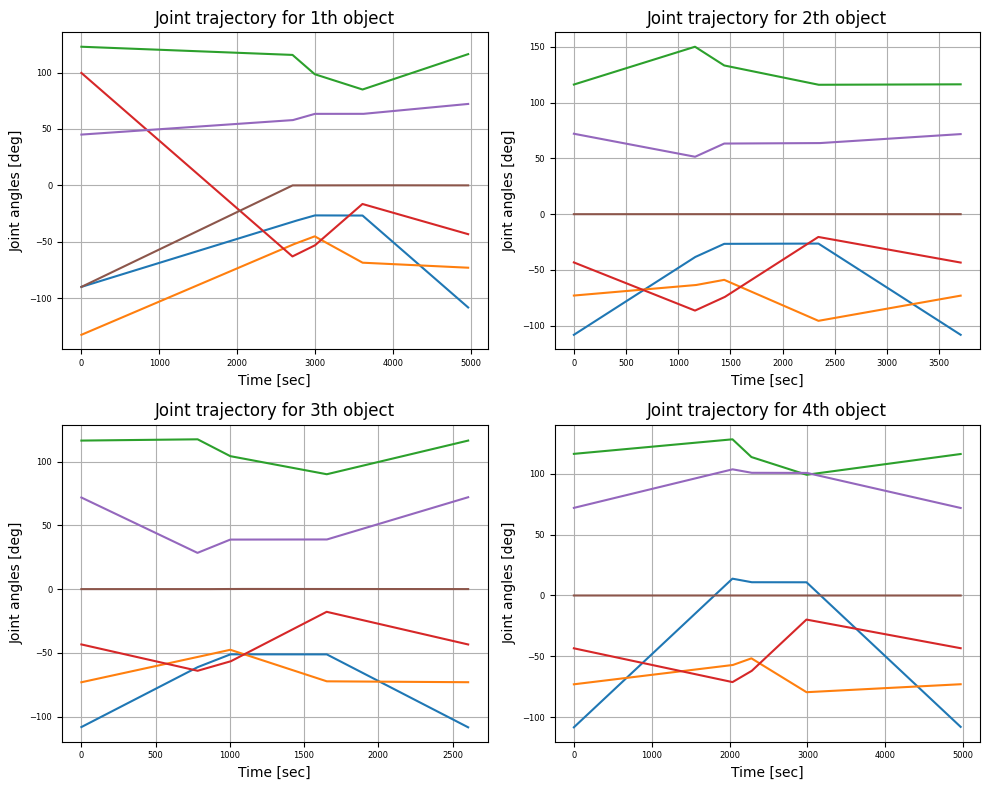

In [17]:
import matplotlib.pyplot as plt
from model.util import get_interp_const_vel_traj

obj_num_sqrt = int(np.ceil(np.sqrt(obj_num)))
fig, axs = plt.subplots(obj_num_sqrt, obj_num_sqrt, figsize=(10, 8))

q_traj_list = []
times_list = []
q_array_flatten = np.concatenate([q_capture.reshape(1,6) ,q_array.reshape(-1,6)])
for q_before, q_after in zip(q_array_flatten[:-1], q_array_flatten[1:]):
    q_array_ = np.vstack([q_before, q_after])
    times, q_traj = get_interp_const_vel_traj(q_array_, vel=np.radians(30), HZ=env.HZ)
    # print("Joint trajectory ready. duration:[%.2f]sec" % (times[-1]))
    
    q_traj_list.append(q_traj)
    times_list.append(times)

for i in range(obj_num):
    q_traj = np.concatenate(q_traj_list[obj_num*(i):obj_num*(i+1)])

    row = i // obj_num_sqrt
    col = i % obj_num_sqrt
    ax = axs[row, col]
    ax.plot(np.degrees(q_traj))
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Joint angles [deg]')
    ax.grid(True)
    title = "Joint trajectory for %dth object" % (i+1)
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [19]:
# Gripper openning should be done by calling step()
env.init_viewer(viewer_title='UR5e with RG2 gripper and objects',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=124.08,distance=4.00,elevation=-33,lookat=[0.1,0.05,0.86],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.2,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,1.0])

# Reset and initialize the joint position
env.reset() # reset

env.forward(q=q_capture,joint_idxs=env.idxs_forward)
env.update_viewer(azimuth=170,distance=2.5,lookat=env.get_p_body(body_name='tcp_link'))

        
# q_array_flatten = q_array.reshape(-1,6)

OPEN = True
CLOSE = False

grasp_list = [OPEN, OPEN, CLOSE, CLOSE]

for i,q_traj_ in enumerate(q_traj_list):
    for q_ in q_traj_:
        start_time = env.get_sim_time()
        
        # while ((env.get_sim_time()-start_time) < time_margin[i%4]):
        
        env.step(ctrl=q_,ctrl_idxs=env.idxs_step)
        env.step(ctrl=float(grasp_list[i%4]),ctrl_idxs=6)

        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_base,R_base = env.get_pR_body(body_name='base')
        env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
        env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.005)
        env.render(render_every=10)

print ("Done.")

# Close viewer
env.close_viewer()

Done.
